# Classic VRPs

This notebook shows how to use PyVRP to solve two classic variants of the VRP: the capacitated vehicle routing problem (CVRP), and the vehicle routing problem with time windows (VRPTW).
It builds on the tutorial by solving much larger instances, and going into more detail about the various plotting tools and diagnostics available in PyVRP.

A CVRP instance is defined on a complete graph $G=(V,A)$, where $V$ is the vertex set and $A$ is the arc set. 
The vertex set $V$ is partitioned into $V=\{0\} \cup V_c$, where $0$ represents the depot and $V_c=\{1, \dots, n\}$ denotes the set of $n$ customers.
Each arc $(i, j) \in A$ has a weight $d_{ij} \ge 0$ that represents the travel distance from $i \in V$ to $j \in V$.
Each customer $i \in V_c$ has a demand $q_{i} \ge 0$.
The objective is to find a feasible solution that minimises the total distance.

A VRPTW instance additionally incorporates time aspects into the problem.
For the sake of exposition we assume the travel duration $t_{ij} \ge 0$ is equal to the travel distance $d_{ij}$ in this notebook.
Each customer $i \in V_c$ has a service time $s_{i} \ge 0$ and a (hard) time window $\left[e_i, l_i\right]$ that denotes the earliest and latest time that service can start.
A vehicle is allowed to arrive at a customer location before the beginning of the time window, but it must wait for the window to open to start the delivery. 
Each vehicle must return to the depot before the end of the depot time window $H$.
The objective is to find a feasible solution that minimises the total distance.

Let's first import what we will use in this notebook.

In [1]:
import matplotlib.pyplot as plt
from tabulate import tabulate
from vrplib import read_solution

from pyvrp import Model, read
from pyvrp.plotting import (
    plot_coordinates,
    plot_instance,
    plot_result,
    plot_route_schedule,
)
from pyvrp.stop import MaxIterations, MaxRuntime

## The capacitated VRP

### Reading the instance

We will solve the `X-n439-k37` instance, which is part of the [X instance set](http://vrp.atd-lab.inf.puc-rio.br/index.php/en/new-instances) that is widely used to benchmark CVRP algorithms.
The function `pyvrp.read` reads the instance file and converts it to a `ProblemData` instance. 
We pass the argument `round_func="round"` to compute the Euclidean distances rounded to the nearest integral, which is the convention for the X benchmark set.
We also load the best known solution to evaluate our solver later on.

In [2]:
INSTANCE = read("data/X-n439-k37.vrp", round_func="round")
BKS = read_solution("data/X-n439-k37.sol")

Let's plot the instance and see what we have.

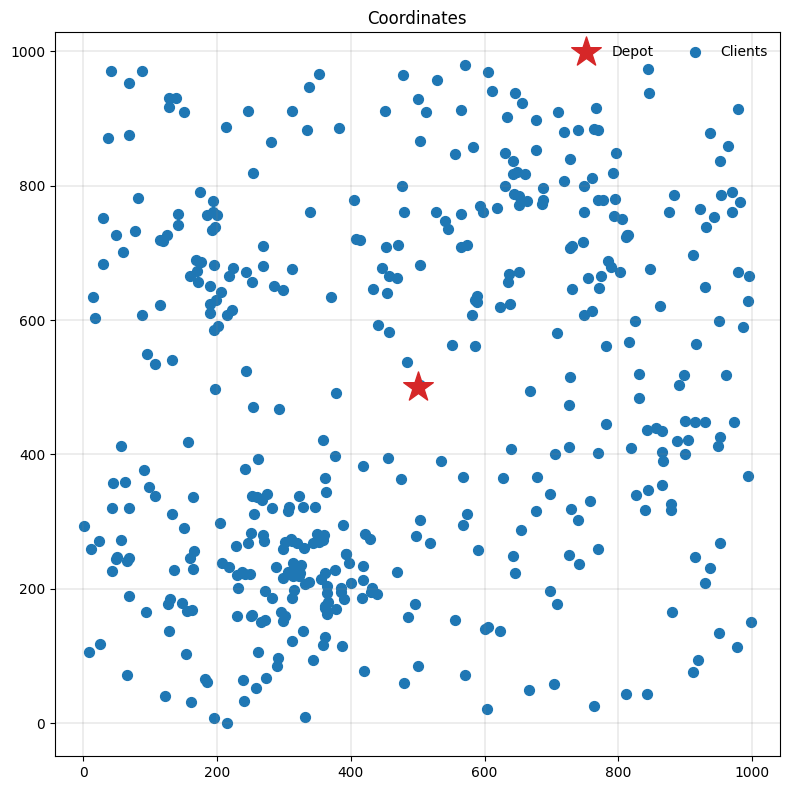

In [3]:
_, ax = plt.subplots(figsize=(8, 8))
plot_coordinates(INSTANCE, ax=ax)
plt.tight_layout()

### Solving the instance

We will again use the `Model` interface to solve the instance.
The `Model` interface supports a convenient `from_data` method that can be used to instantiate a model from a known `ProblemData` object.

In [4]:
model = Model.from_data(INSTANCE)
result = model.solve(stop=MaxIterations(2000), seed=42, display=False)
print(result)

Solution results
    # routes: 37
   # clients: 438
   objective: 36634
    distance: 36634
    duration: 36634
# iterations: 2000
    run-time: 48.19 seconds

Routes
------
Route #1: 414 217 236 434 8 311 133 370 3 169 2 105 
Route #2: 348 411 410 349 425 223 299 386 267 400 97 72 
Route #3: 326 26 260 92 275 41 406 270 308 202 149 172 
Route #4: 237 312 250 211 347 43 296 375 218 239 42 335 
Route #5: 155 71 228 346 162 166 345 385 438 381 404 195 
Route #6: 435 281 206 57 392 139 200 145 122 366 418 421 
Route #7: 393 280 303 225 388 409 110 245 241 360 342 221 
Route #8: 44 324 115 229 268 380 227 249 325 121 353 422 
Route #9: 377 433 337 242 372 391 423 396 420 413 321 243 
Route #10: 83 412 416 407 384 403 17 89 293 428 193 285 
Route #11: 264 352 315 86 297 126 66 339 402 101 252 309 
Route #12: 383 257 253 289 271 338 319 329 266 351 432 233 
Route #13: 65 154 7 197 344 118 91 215 153 15 159 283 
Route #14: 251 137 98 341 350 286 47 376 138 246 323 437 
Route #15: 1 140 274 11

In [5]:
gap = 100 * (result.cost() - BKS["cost"]) / BKS["cost"]
print(f"Found a solution with cost: {result.cost()}.")
print(f"This is {gap:.1f}% worse than the best known", end=" ")
print(f"solution, which is {BKS['cost']}.")

Found a solution with cost: 36634.
This is 0.7% worse than the best known solution, which is 36391.


We've managed to find a very good solution quickly!

The `Result` object also contains useful statistics about the optimisation.
We can now plot these statistics as well as the final solution use `plot_result`.

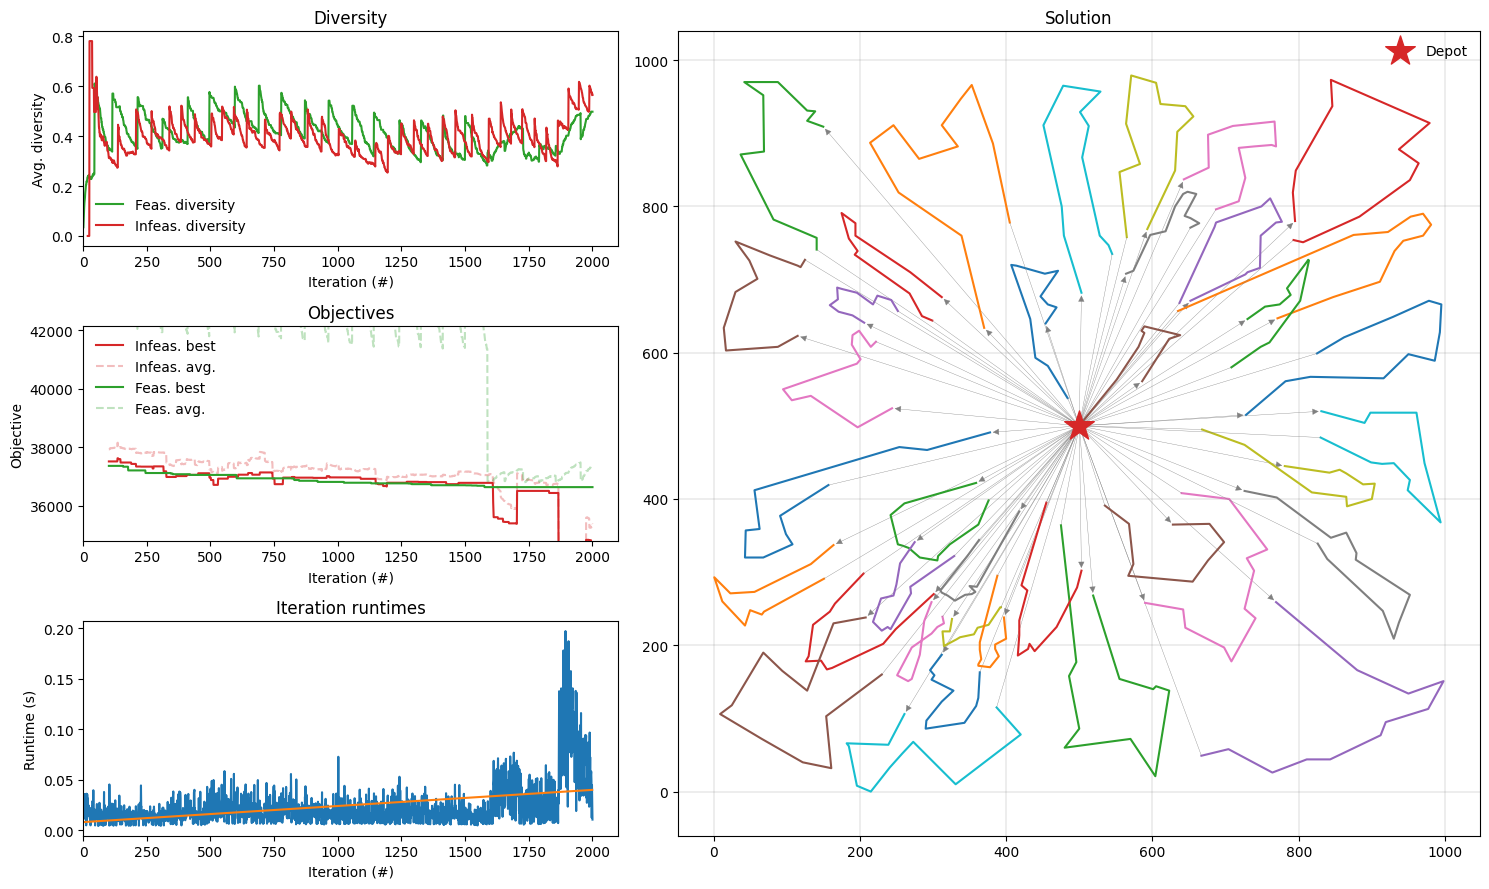

In [6]:
fig = plt.figure(figsize=(15, 9))
plot_result(result, INSTANCE, fig)
fig.tight_layout()

PyVRP internally uses a genetic algorithm consisting of a population of feasible and infeasible solutions.
These solutions are iteratively combined into new offspring solutions, that should result in increasingly better solutions. 
Of course, the solutions should not all be too similar: then there is little to gain from combining different solutions.
The top-left *Diversity* plot tracks the average diversity of solutions in each of the feasible and infeasible solution populations.
The *Objectives* plot gives an overview of the best and average solution quality in the current population.
The bottom-left figure shows iteration runtimes in seconds.
Finally, the *Solution* plot shows the best observed solution.

## The VRP with time windows

### Reading the instance

We start with a basic example that loads an instance and solves it using the standard configuration used by the `Model` interface.
For the basic example we use one of the well-known Solomon instances.

We again use the function `pyvrp.read`. We pass the argument `round_func="dimacs"` following the [DIMACS VRP challenge](http://dimacs.rutgers.edu/programs/challenge/vrp/) convention, this computes distances and durations truncated to one decimal place.

In [7]:
INSTANCE = read("data/RC208.vrp", round_func="dimacs")
BKS = read_solution("data/RC208.sol")

Let's plot the instance and see what we have.
The function `plot_instance` will plot time windows, delivery demands and coordinates, which should give us a good impression of what the instance looks like.
These plots can also be produced separately by calling the appropriate `plot_*` function: see [the API documentation](https://pyvrp.readthedocs.io/en/latest/api/plotting.html) for details.

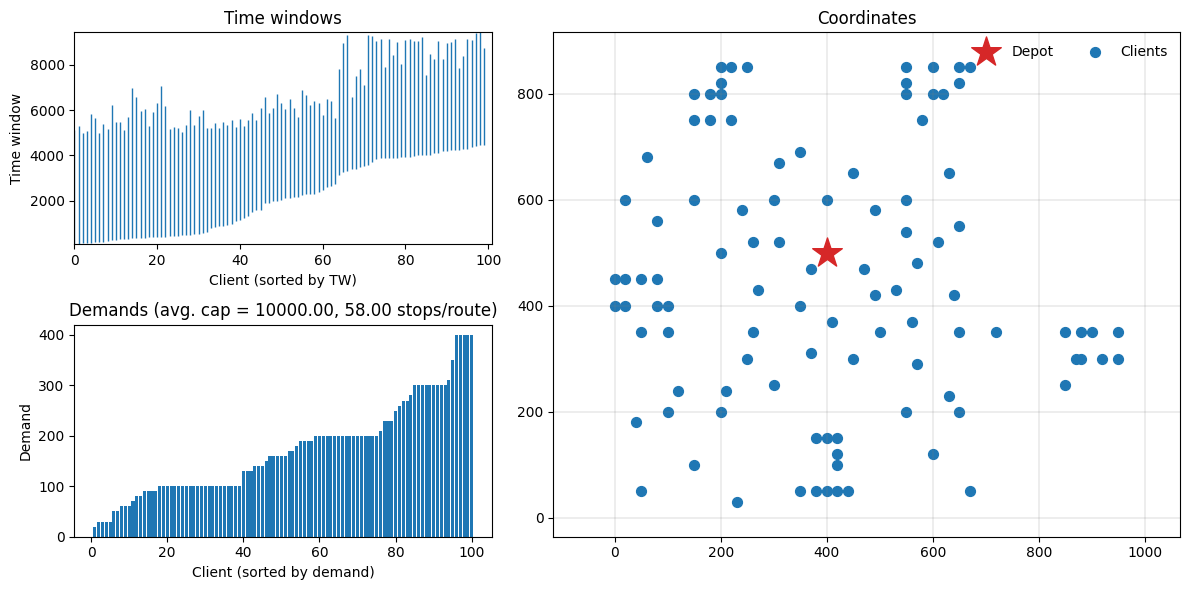

In [8]:
fig = plt.figure(figsize=(12, 6))
plot_instance(INSTANCE, fig)

### Solving the instance

We will again use the `Model` interface to solve the instance.

In [9]:
model = Model.from_data(INSTANCE)
result = model.solve(stop=MaxIterations(1000), seed=42, display=False)
print(result)

Solution results
    # routes: 4
   # clients: 100
   objective: 7765
    distance: 7765
    duration: 17765
# iterations: 1000
    run-time: 2.35 seconds

Routes
------
Route #1: 69 98 88 2 6 7 79 73 78 12 14 47 17 16 15 13 9 11 10 53 60 8 46 4 45 5 3 1 70 100 55 68 
Route #2: 90 82 99 52 57 49 19 18 48 21 23 25 77 58 75 97 59 87 86 74 24 22 20 66 
Route #3: 65 83 64 51 85 63 76 89 33 30 32 28 26 27 29 31 34 50 62 84 56 91 
Route #4: 92 95 67 71 72 41 39 38 37 35 36 40 43 44 42 61 81 54 96 93 94 80 



In [10]:
cost = result.cost() / 10
gap = 100 * (cost - BKS["cost"]) / BKS["cost"]
print(f"Found a solution with cost: {cost}.")
print(f"This is {gap:.1f}% worse than the optimal solution,", end=" ")
print(f"which is {BKS['cost']}.")

Found a solution with cost: 776.5.
This is 0.1% worse than the optimal solution, which is 776.1.


We've managed to find a (near) optimal solution in a few seconds!

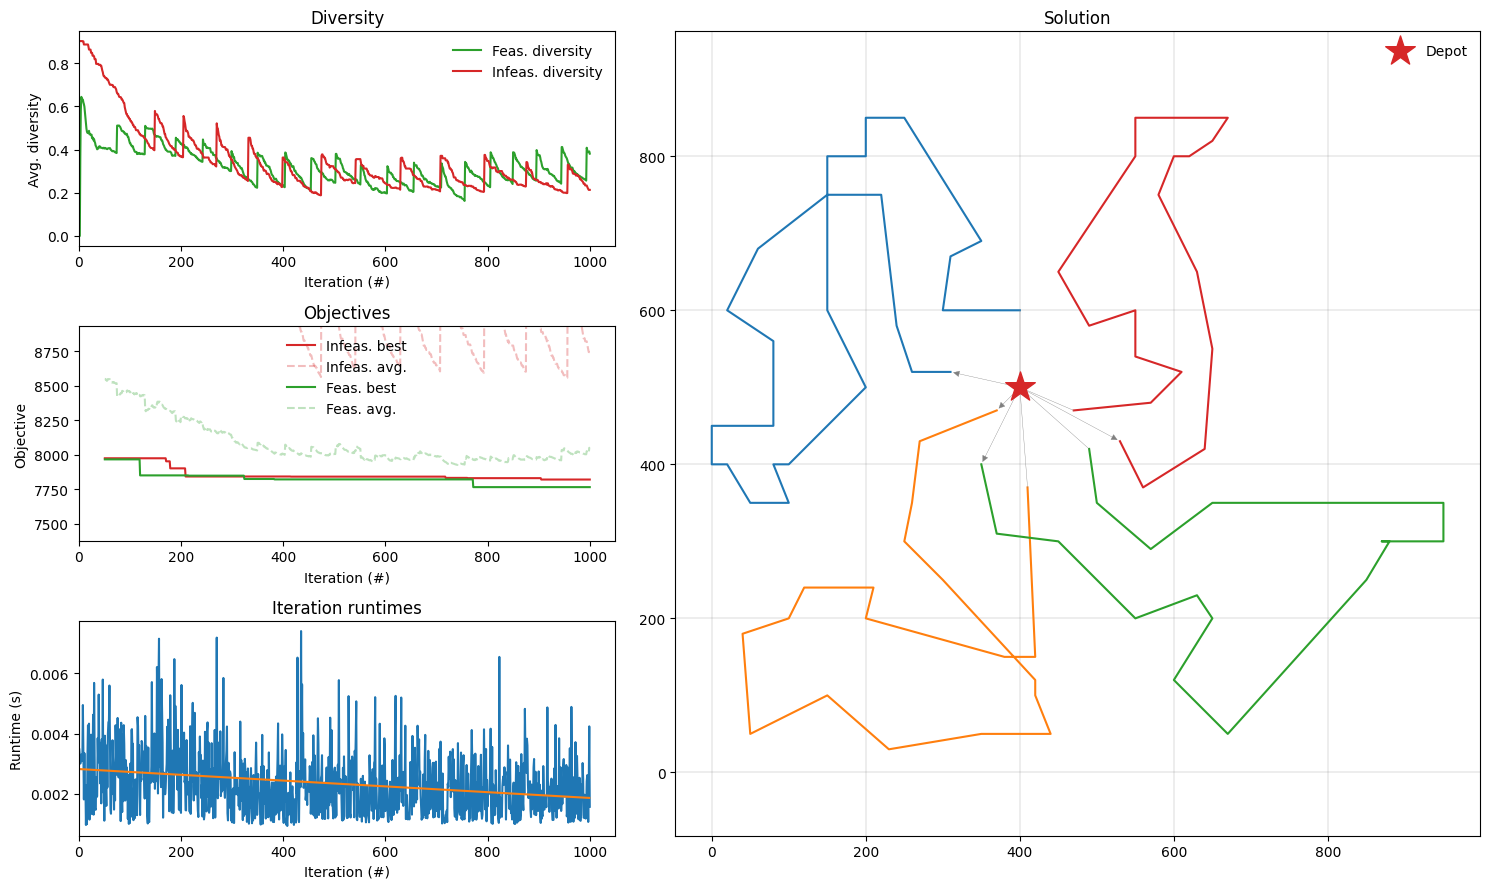

In [11]:
fig = plt.figure(figsize=(15, 9))
plot_result(result, INSTANCE, fig)
fig.tight_layout()

We can also inspect some statistics of the different routes, such as route distance, various durations, the number of stops and total delivery amount.

In [12]:
solution = result.best
routes = solution.routes()

data = [
    {
        "num_stops": len(route),
        "distance": route.distance(),
        "service_duration": route.service_duration(),
        "wait_duration": route.wait_duration(),
        "time_warp": route.time_warp(),
        "delivery": route.delivery(),
    }
    for route in routes
]

header = list(data[0].keys())
rows = [datum.values() for datum in data]
tabulate(rows, header, tablefmt="html")

num_stops,distance,service_duration,wait_duration,time_warp,delivery
32,2266,3200,0,0,5920
24,1970,2400,0,0,4180
22,1886,2200,0,0,3630
22,1643,2200,0,0,3510


We can inspect the routes in more detail using the `plot_route_schedule` function.
This will plot distance on the x-axis, and time on the y-axis, separating actual travel/driving time from waiting and service time.
The clients visited are plotted as grey vertical bars indicating their time windows.
We can see a jump to the start of the time window in the main (earliest) time line when a vehicle arrives early at a customer and has to wait.
In some cases, there is slack in the route indicated by a semi-transparent region on top of the earliest time line.
The grey background indicates the remaining load of the truck during the route, where the (right) y-axis ends at the vehicle capacity.

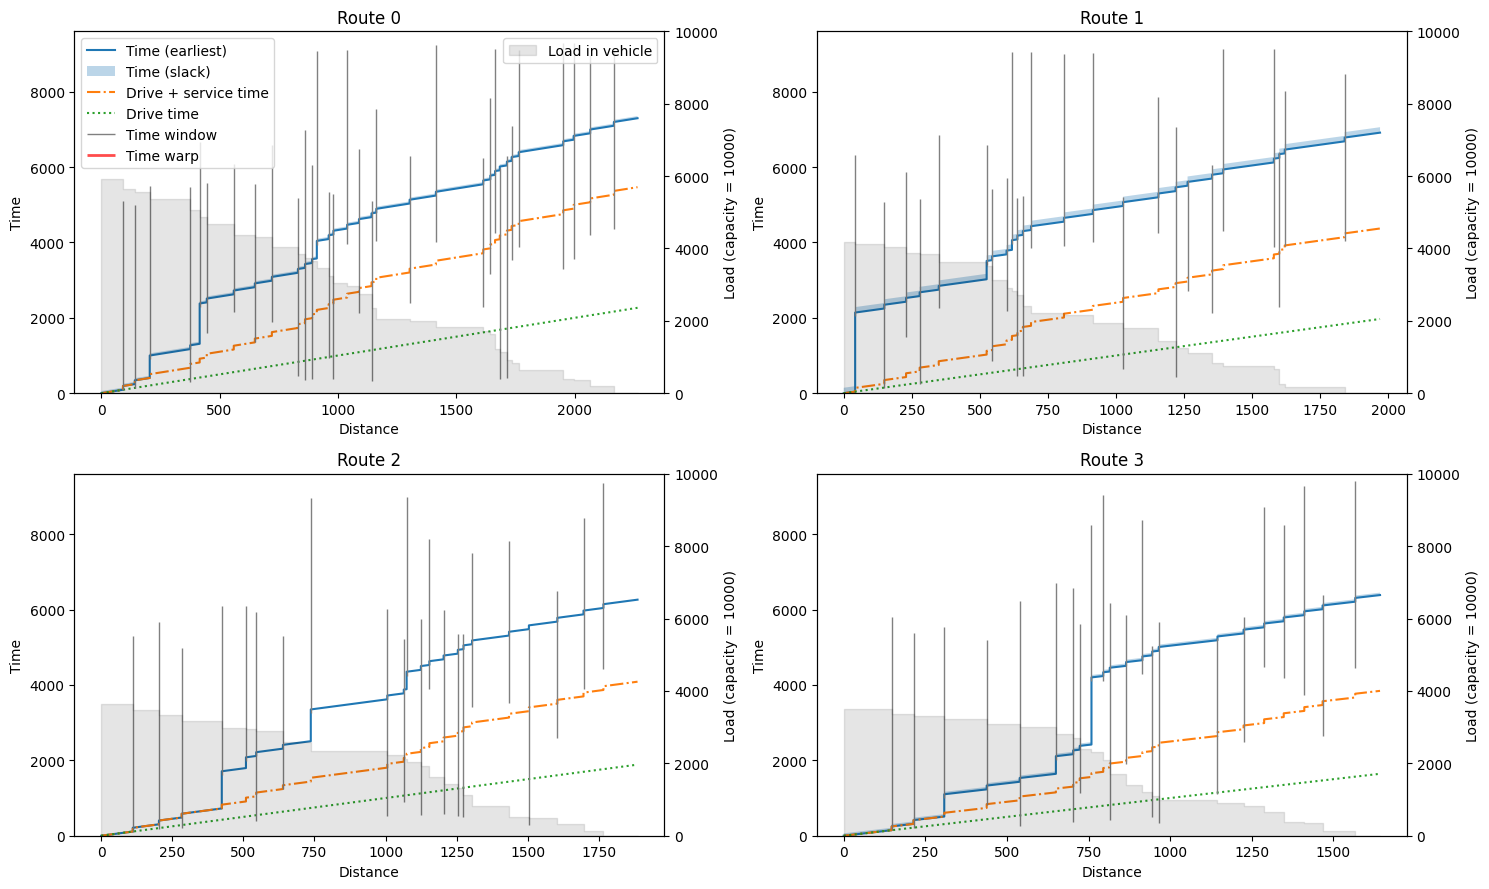

In [13]:
fig, axarr = plt.subplots(2, 2, figsize=(15, 9))
for idx, (ax, route) in enumerate(zip(axarr.reshape(-1), routes)):
    plot_route_schedule(
        INSTANCE,
        route,
        title=f"Route {idx}",
        ax=ax,
        legend=idx == 0,
    )

fig.tight_layout()

## Solving a larger VRPTW instance

To show that PyVRP can also handle much larger instances, we will solve one of the largest Gehring and Homberger VRPTW benchmark instances.
The selected instance - `RC2_10_5` - has 1000 clients.

In [14]:
INSTANCE = read("data/RC2_10_5.vrp", round_func="dimacs")
BKS = read_solution("data/RC2_10_5.sol")

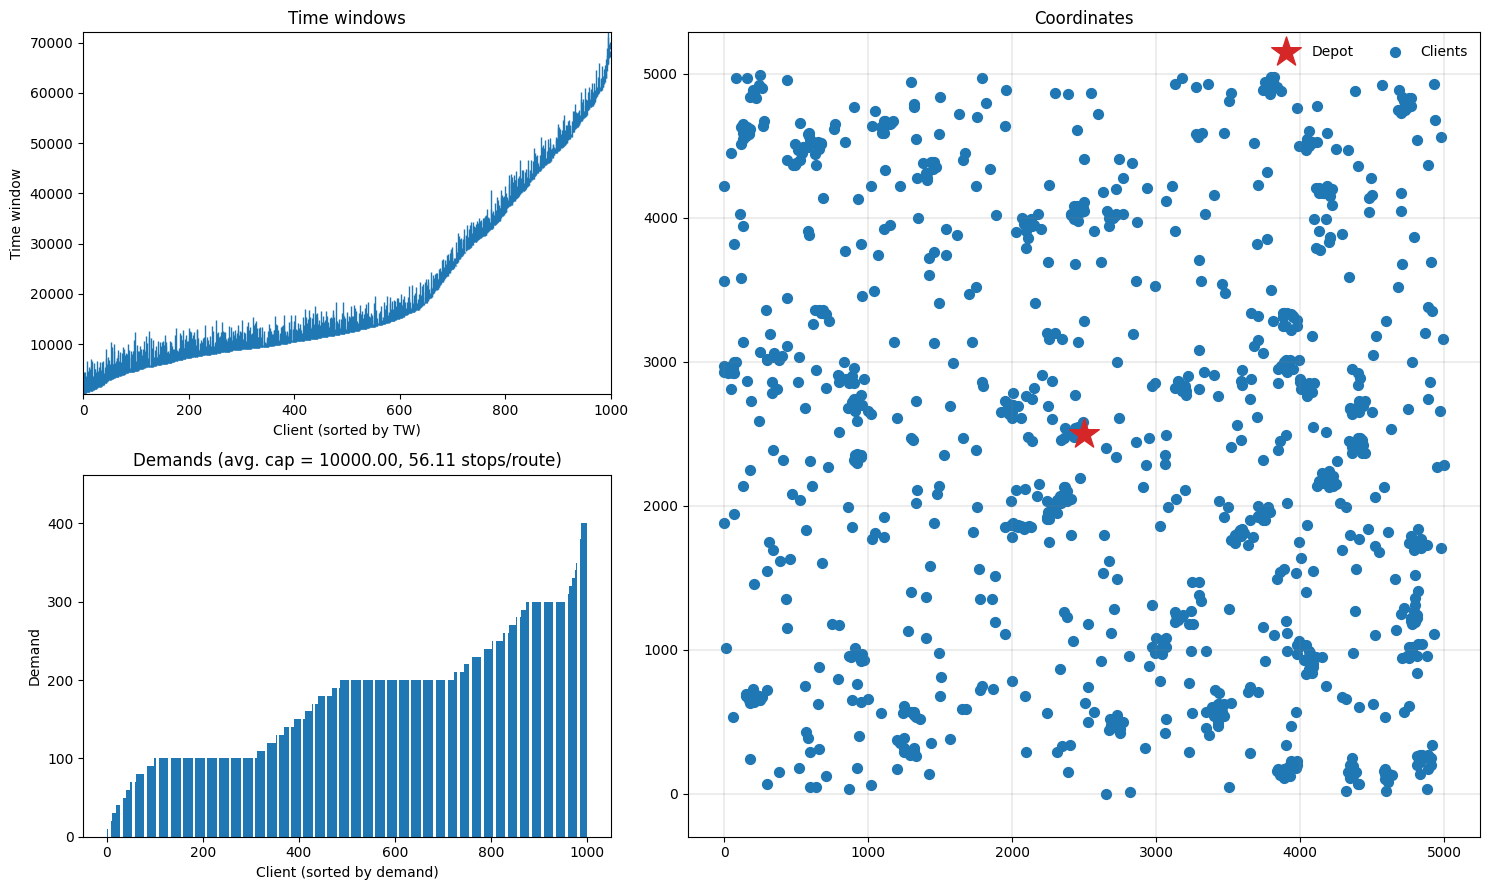

In [15]:
fig = plt.figure(figsize=(15, 9))
plot_instance(INSTANCE, fig)

Here, we will use a runtime-based stopping criterion: we give the solver 30 seconds to compute.

In [16]:
model = Model.from_data(INSTANCE)
result = model.solve(stop=MaxRuntime(30), seed=42, display=False)

In [17]:
cost = result.cost() / 10
gap = 100 * (cost - BKS["cost"]) / BKS["cost"]
print(f"Found a solution with cost: {cost}.")
print(f"This is {gap:.1f}% worse than the best-known solution,", end=" ")
print(f"which is {BKS['cost']}.")

Found a solution with cost: 27199.0.
This is 5.4% worse than the best-known solution, which is 25797.5.


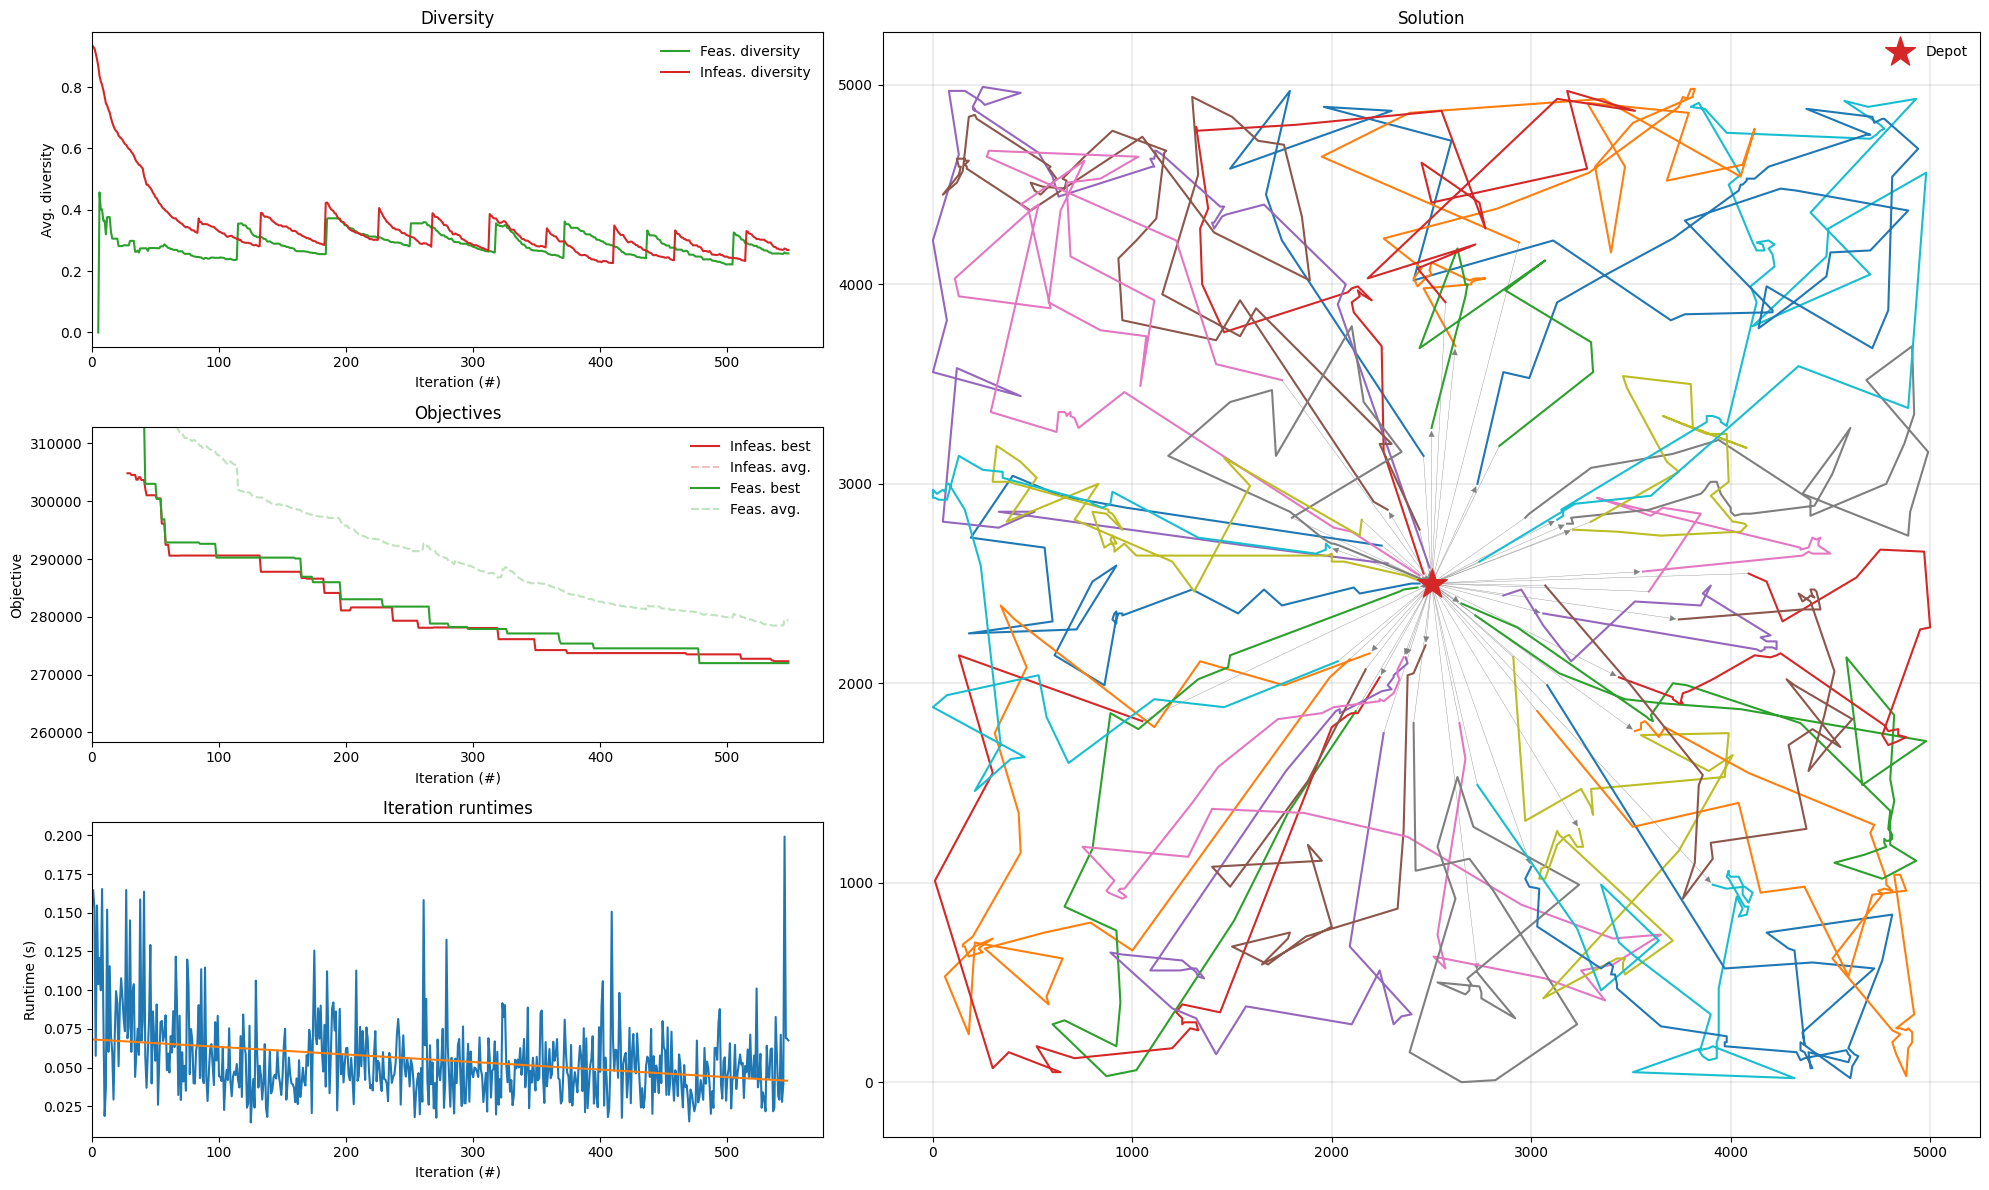

In [18]:
plot_result(result, INSTANCE)
plt.tight_layout()

## Conclusion

In this notebook, we used PyVRP's `Model` interface to solve a CVRP instance with 438 clients to near-optimality, as well as several VRPTW instances, including a large 1000 client instance.
Moreover, we demonstrated how to use the plotting tools to visualise the instance and statistics collected during the search procedure.